In [12]:
import os
import math
import fiftyone as fo
import fiftyone.brain as fob
from fiftyone import ViewField as F
from typing import Any, Dict, List, Optional, Tuple

## Visualize and remove duplicates

In [13]:
dataset_dir = "../data/Documents/"
train_dir = "../data/train/"
val_dir = "../data/val/"
dataset = fo.Dataset.from_dir(
    dataset_dir=val_dir,
    dataset_type=fo.types.ImageClassificationDirectoryTree
)

 100% |█████████████████| 219/219 [97.3ms elapsed, 0s remaining, 2.2K samples/s]   


In [14]:
fob.compute_uniqueness(dataset)
# print(dataset.first())

Computing embeddings...
 100% |█████████████████| 219/219 [5.9s elapsed, 0s remaining, 37.6 samples/s]      
Computing uniqueness...
Uniqueness computation complete



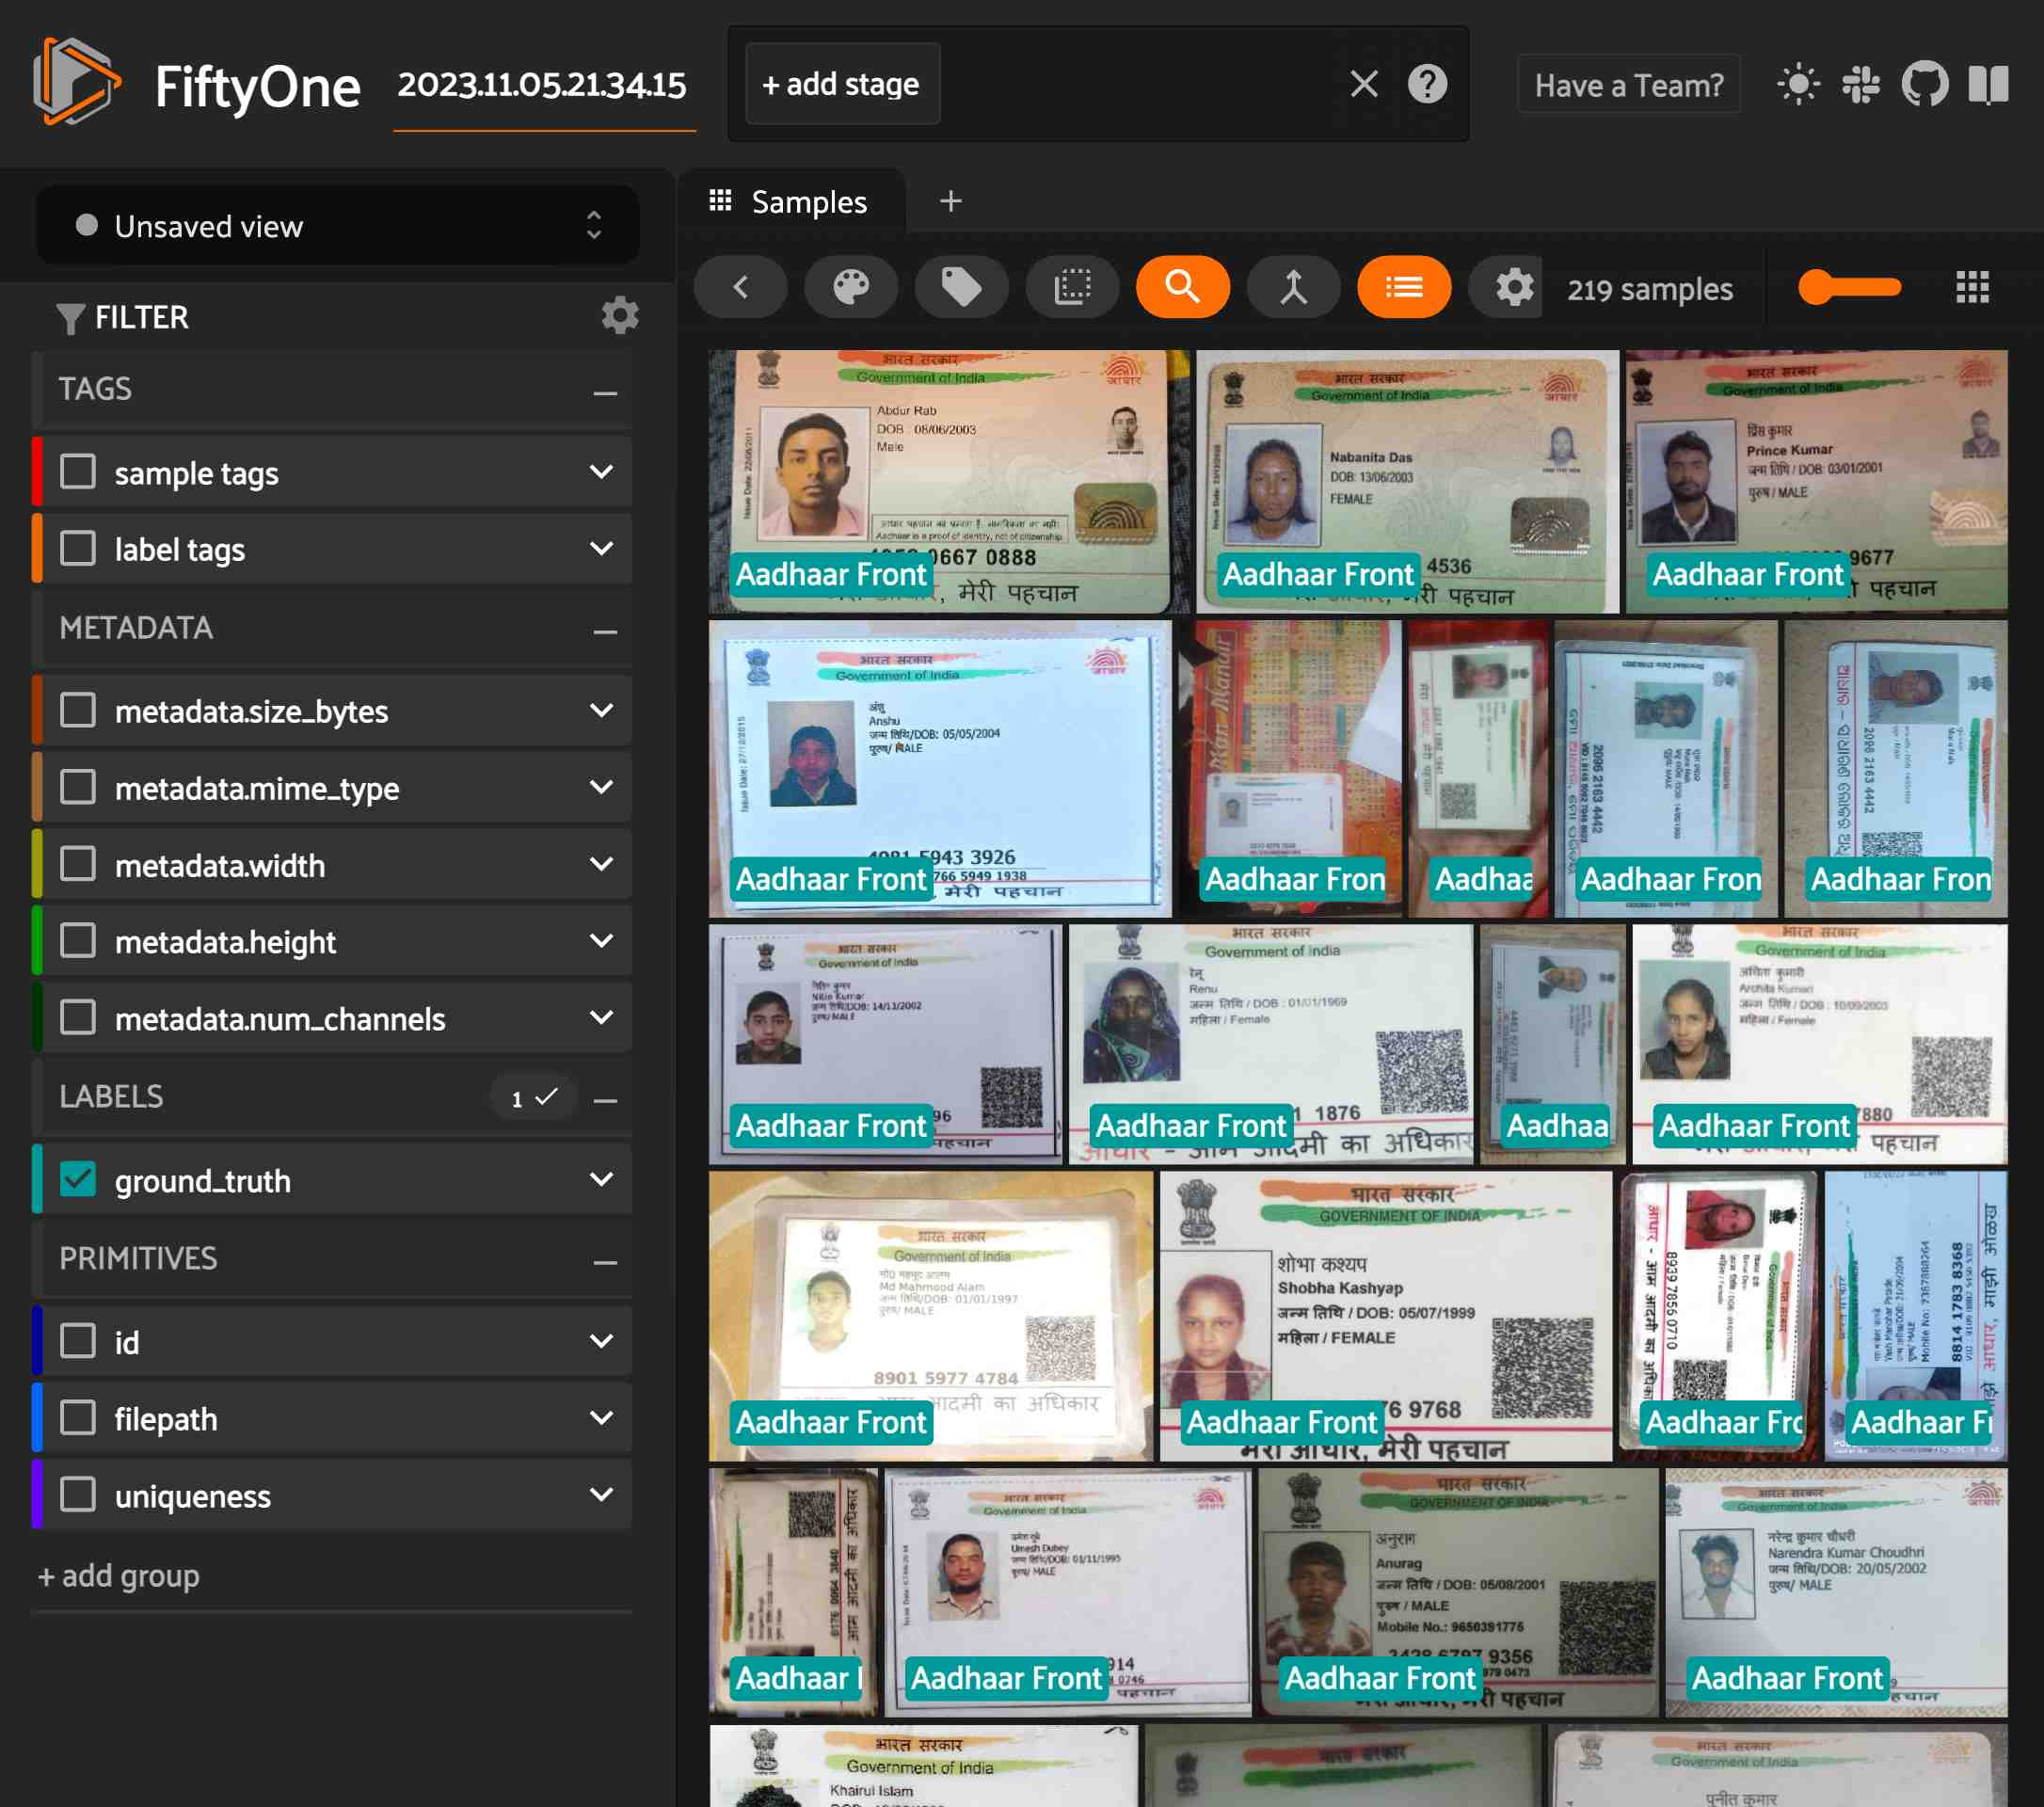

In [15]:
session = fo.launch_app(dataset)

In [16]:
# Sort in increasing order of uniqueness (least unique first)
dups_view = dataset.sort_by("uniqueness")

# Open view in the App
session.view = dups_view


Could not connect session, trying again in 10 seconds

Could not connect session, trying again in 10 seconds

Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds




Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds

Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds



Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds

Could not connect session, trying again in 10 se

In [ ]:
def remove_dupes(sorted_data: List[fo.Sample], rtol: float = 1e-9) -> Tuple[List[fo.Sample], set[str]]:
    """This function removes duplicates in a dataset sorted by uniqueness value.
    Returns a de-duplicated dataset and a list of filepaths of duplicates"""
    assert len(sorted_data) >= 2, "No duplicates"
    dup_paths: set[str] = set()
    dedupe_dataset: List[fo.Sample] = []
    for i in range(0, len(sorted_data)-1):
        for j in range(i+1, len(sorted_data)):
            if math.isclose(sorted_data[i]['uniqueness'], sorted_data[j]['uniqueness'], rel_tol=rtol):
                dup_paths.add(sorted_data[j]['filepath'])
            else:
                break
        if sorted_data[i]['filepath'] not in dup_paths:
            dedupe_dataset.append(sorted_data[i])
    
    return dedupe_dataset, dup_paths

In [ ]:
# Sort the dataset by uniqueness
sorted_dataset = sorted(dataset, key=lambda x: x["uniqueness"]) # list of samples

In [ ]:
deduped_dataset_list, dup_paths = remove_dupes(sorted_dataset, 1e-5)
deduped_dataset = fo.Dataset()
deduped_dataset.add_samples(deduped_dataset_list)

### Remove duplicate images using uniqueness

In [ ]:
dup_paths

In [ ]:
not_found_cnt = 0
# Iterate through the list of paths and delete the files if they exist
for path in dup_paths:
    if os.path.exists(path):
        try:
            os.remove(path)  # Delete the file
            print(f"Deleted: {path}")
        except OSError as e:
            print(f"Error deleting {path}: {e}")
    else:
        print(f"File not found: {path}")
        not_found_cnt += 1

In [ ]:
not_found_cnt

In [ ]:
session = fo.launch_app(deduped_dataset)

In [ ]:
deduped_dataset.name = "Deduped dataset - automatic1" # any name
deduped_dataset.persistent = True

## Delete duplicate images (depricated)

In [ ]:
all_datasets = fo.list_datasets()
all_datasets

In [ ]:
dataset = fo.load_dataset('Deduped dataset - automatic1')
session = fo.launch_app(dataset) # optionally view the saved dataset
unique_images = [sample['filepath'] for sample in dataset]
unique_images

**Note**: below code isn't working. Deletes entire directory

In [ ]:
start_directory = "../data/Documents/"
# Recursively traverse the directory and delete files not in the list
for root, dirs, files in os.walk(start_directory):
    for filename in files:
        file_path = os.path.abspath(os.path.join(root, filename))
        # print(file_path)
        if filename not in unique_images:
            try:
                os.remove(file_path)  # Delete the file
                print(f"Deleted: {file_path}")
            except OSError as e:
                print(f"Error deleting {file_path}: {e}")

print("Deletion process complete.")

## Manually tag duplicates and annotation mistakes

In [2]:
fo.list_datasets()

['Deduped dataset - automatic',
 'Deduped dataset - automatic1',
 'Documents Dataset',
 'Documents Dataset - Cleaned']

In [3]:
dataset = fo.load_dataset("Documents Dataset")

In [4]:
dataset.list_saved_views()

['duplicates',
 'INCORRECT predictions on val split',
 'hardest false positives',
 'annotation mistakes']


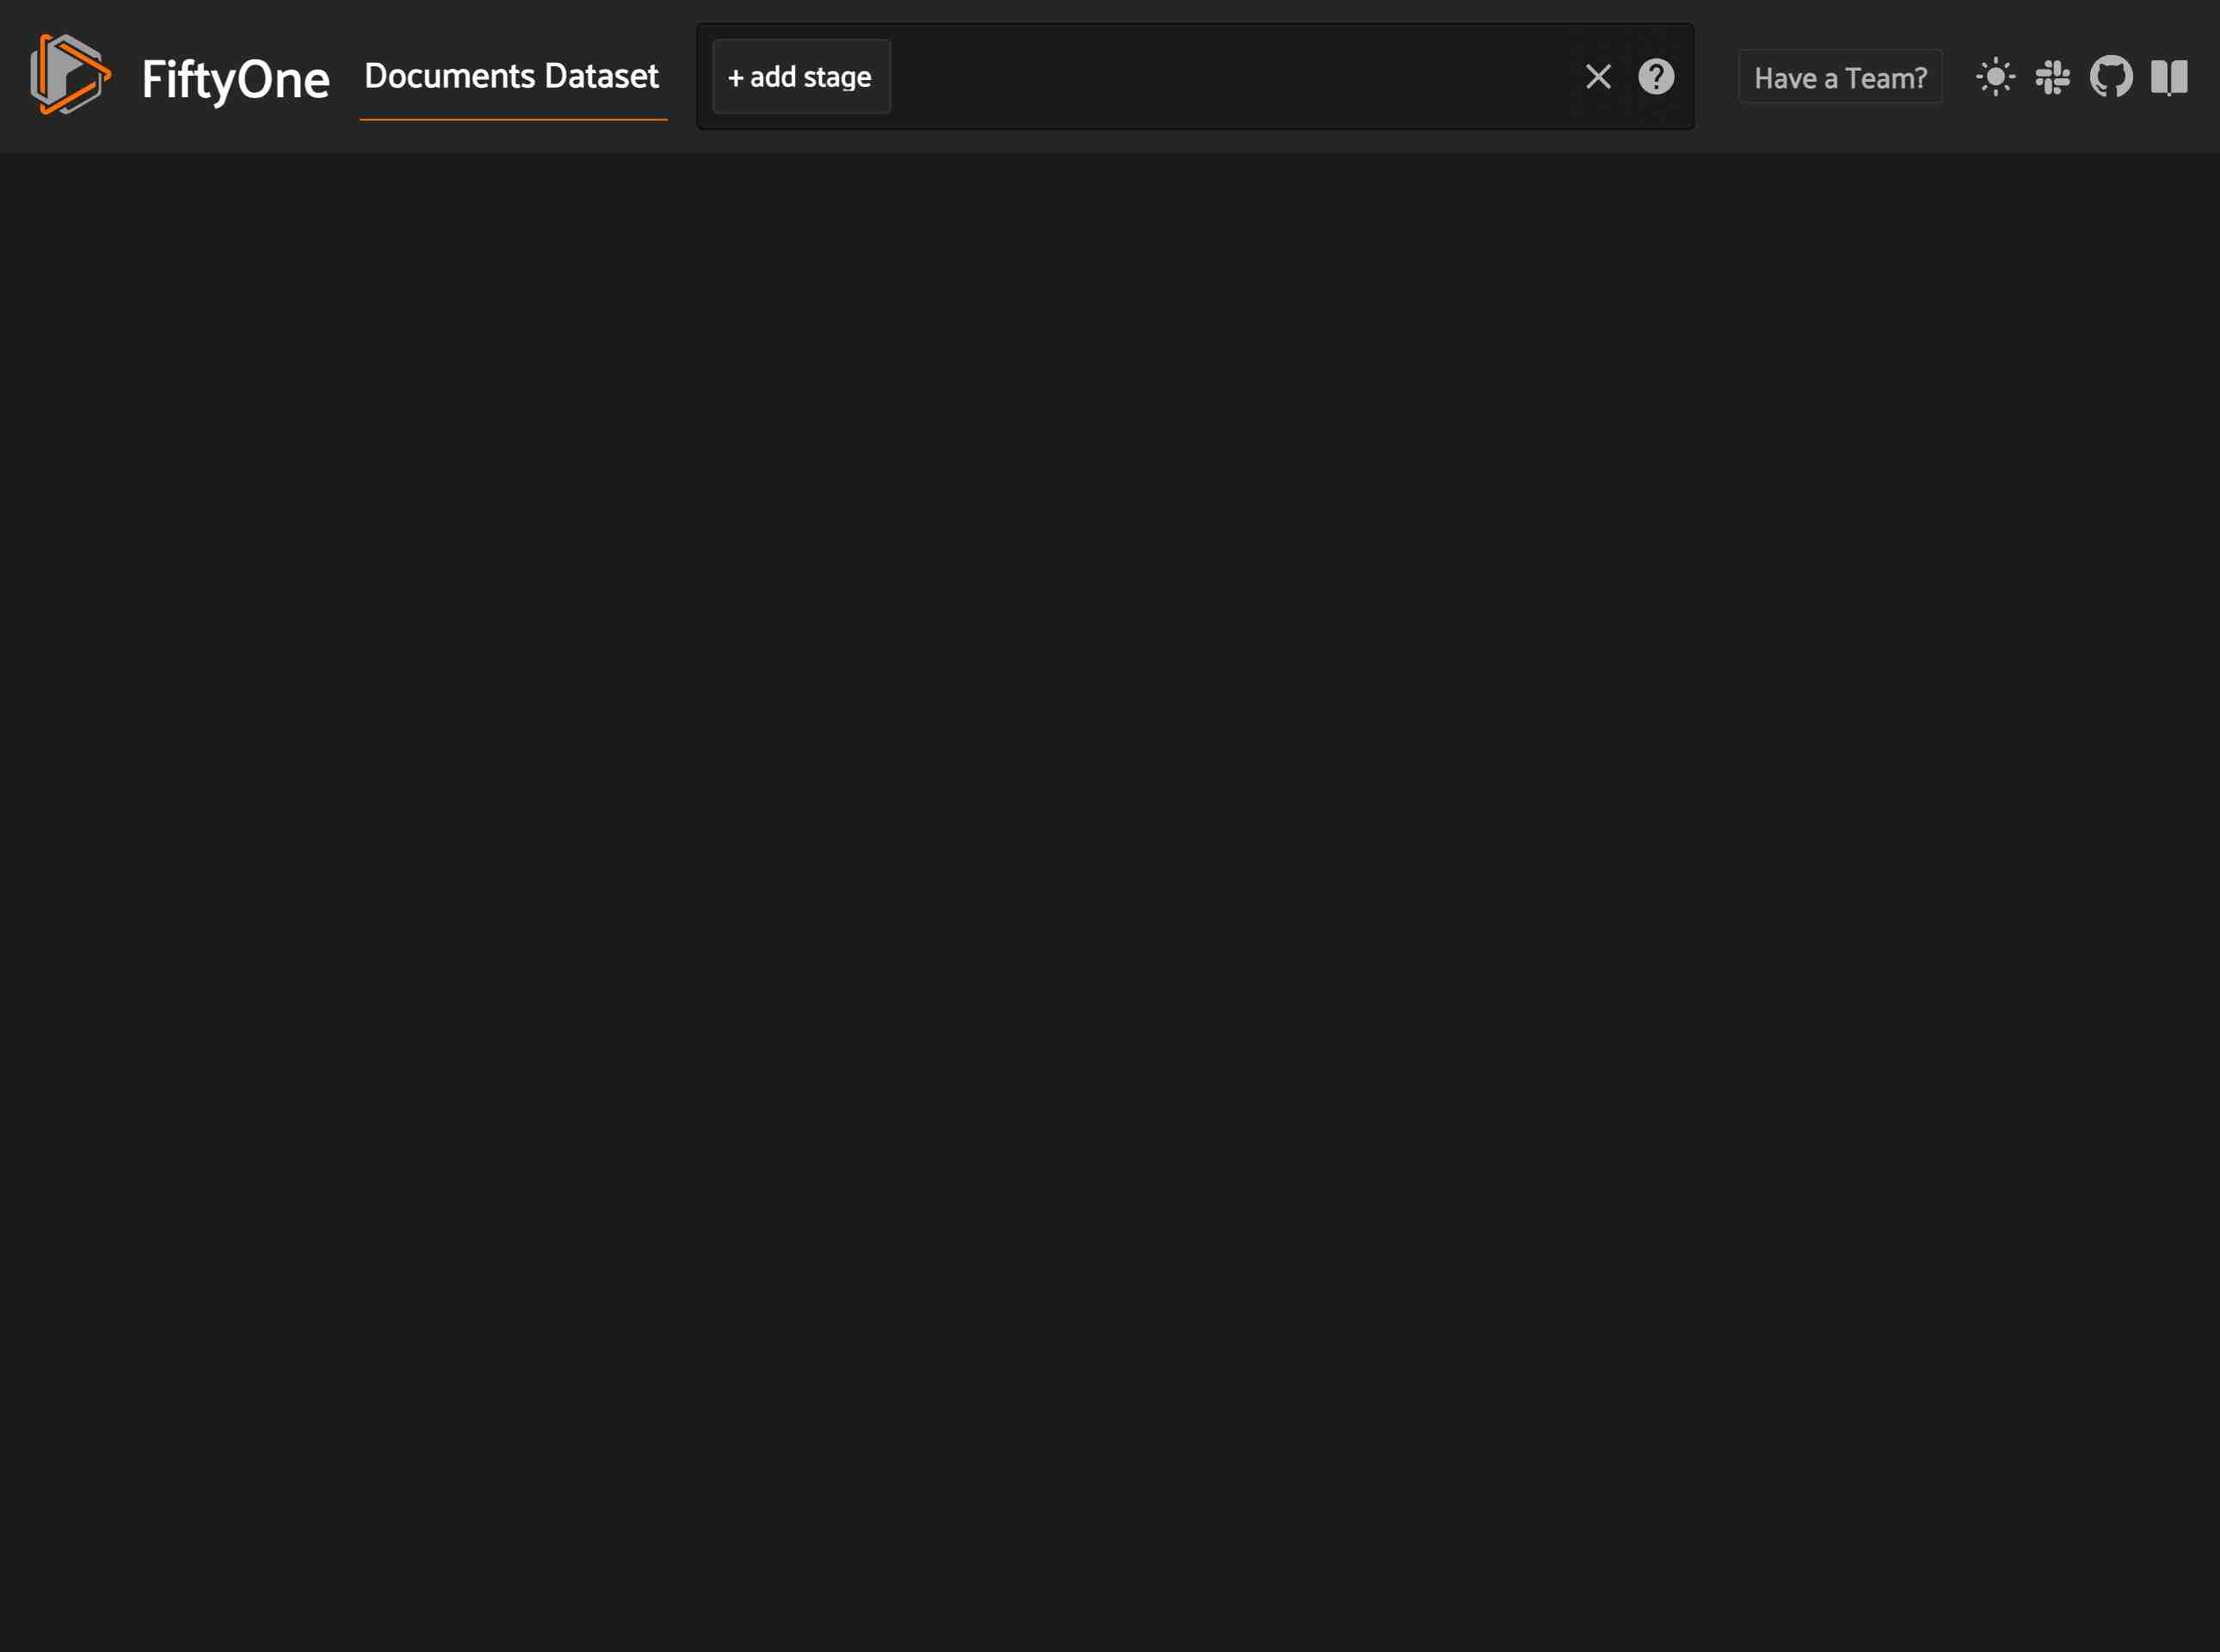

In [5]:
annotation_mistakes_view = dataset.load_saved_view("annotation mistakes")
session = fo.launch_app(dataset)

In [8]:
# create a view of the selected samples
sample_ids = session.selected
selected_view = dataset.select(session.selected)

In [9]:
# Save the view
dataset.save_view("annotation-mistakes-view", selected_view)

In [10]:
# tag annotation mistake samples
selected_view.tag_samples("annotation_mistake")

## Export dataset without duplicates and annotation mistakes (based on Tag)

In [17]:
# Only include samples that do not have the "annotation_mistake" or "duplicate" tags
export_dataset = dataset.match_tags(["annotation_mistake", "duplicate"], bool=False)
cnt = export_dataset.count()
cnt

975

In [19]:
session.view = export_dataset

In [6]:
# Only include samples that do not have the "duplicate" tag
export_dataset_new = dataset.match_tags(["duplicate"], bool=False)
cnt = export_dataset_new.count()
cnt

945

In [7]:
version = "4"
export_dir = f"~/Datasets/DocumentsV{version}/"
label_field = "ground_truth"
export_dataset_new.export(
    export_dir=export_dir,
    dataset_type=fo.types.ImageClassificationDirectoryTree,
    label_field=label_field,
)

   0% ||----------------|   0/945 [5.6ms elapsed, ? remaining, ? samples/s] 

 100% |█████████████████| 945/945 [1.6s elapsed, 0s remaining, 766.4 samples/s]      


## Label Studio (not working)

In [ ]:
# A unique identifier for this run
anno_key = "labelstudio_annotation_mistakes"
selected_view.annotate(
    anno_key,
    backend="labelstudio",
    launch_editor=False,
    url="http://localhost:8081",
    label_type="classification",
    label_field="ground_truth",
    project_name="Id_classification_mislabelled"
)

In [ ]:
dataset.save()